In [1]:
# create a function (maybe called "evaluate") that evaluates a 
# model using the equation from Thomas' email. 
# The function will take a sample pandas data (x rows) as input, calculate del.gamma1/del.x1 and del.gamma2/del.x2 
# from the input data, and then calculate the left-hand side value from the equation, 
# creating a x length array for each x1 and x2 from the input data. 
# Plot a graph of this output x length array against x1.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import mean_squared_error,r2_score
import statistics
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from scipy.integrate import simps
from numpy import trapz

### Loading the PINN model

In [4]:
class Model2(nn.Module):
    def __init__(self, input_dim):
        super(Model2, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = self.layer5(x)
        return x

In [5]:
device = torch.device("cpu")

In [6]:
# Path_model_k_5 = './Model/Server/PINN_Model_2_epochs_5000_K_5_new_embedding.pt'
# Path_model_k_10 = './Model/Server/PINN_Model_2_epochs_5000_K_10_new_embedding.pt'
# Path_model_k_25 = './Model/Server/PINN_Model_2_epochs_5000_K_25_new_embedding.pt'
# Path_model_k_50 = './Model/Server/PINN_Model_2_epochs_5000_K_50_new_embedding.pt'
# Path_model_k_100 = './Model/Server/PINN_Model_2_epochs_5000_K_100_new_embedding.pt'
# Path_model_k_250 = './Model/Server/PINN_Model_2_5000_epochs_K_250_new_embedding.pt'
# Path_model_k_500 = './Model/Server/PINN_Model_2_5000_epochs_K_500_new_embedding.pt'
# Path_model_k_750 = './Model/Server/PINN_Model_2_epochs_5000_K_750_new_embedding.pt'
# Path_model_k_800 = './Model/Server/PINN_Model_2_epochs_5000_K_800_new_embedding.pt'
# Path_model_seed_42 = './Model/Server/PINN_Model_2_epochs_5000_seed_42_new_embedding.pt'
# Path_model_random_1 = './Embeddings_train_from_scratch/Models_Trained/PINN_Model_2_epochs_5000_new_embeddings_random_1.pt'
# Path_model_random_2 = './Embeddings_train_from_scratch/Models_Trained/PINN_Model_2_epochs_5000_new_embeddings_random_2.pt'
# Path_model_random_3 = './Embeddings_train_from_scratch/Models_Trained/PINN_Model_2_epochs_5000_new_embeddings_random_3.pt'
# Path_model_random_4 = './Embeddings_train_from_scratch/Models_Trained/PINN_Model_2_epochs_5000_new_embeddings_random_4.pt'
# Path_model_random_5 = './Embeddings_train_from_scratch/Models_Trained/PINN_Model_2_epochs_5000_new_embeddings_random_5.pt'
# Path_model_seed_1234_NN = '../Training based on Smile Combination/NN_training/model_1234.pt'
# Path_model_seed_1234_PINN = '../Training based on Smile Combination/NN_PIINN_training/model_1234_pinn.pt'
# Path_model_seed_1234_PINN_early_stopping_patience_20 = '../Training based on Smile Combination/Early_stopping/model_1234_pinn_early_stopping.pt'

In [83]:
model = Model2(2803)
# Load
PATH = 'model_10_PINN.pt'
model = torch.load(PATH)
model.eval()

Model2(
  (layer1): Linear(in_features=2803, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=2, bias=True)
)

### Evaluation of the Model using  [ x1 * ln(gamma1) - x2 * ln(gamma2) ]

In [84]:
# Evaluation using the equation [ x1*ln(gamma1) - x2*ln*gamma2) ] which needs to be around zero. 
# If it is near zero it suggests that the predictions by the model are accurate.
def evaluate(smile1, smile2, model):
    
    # Fetching the data
    data = get_smile_data(smile1, smile2)
    
    # Getting Input and Ouput from the data
    X = data[:,:-2]
    y = data[:,-2:]

    X = Variable(torch.from_numpy(X)).float().requires_grad_(True)
    y = Variable(torch.from_numpy(y)).float()
    
    # Getting x1 and x2 concentration from the input data
    x1 = X[:,-3]
    x2 = X[:,-2]
        
    # Prediction of ln(gamma1) and ln(gamma2) using the PINN Model
    y_pred = model(X)
    
    # Calculation of x1*d_lngamma1_x1 - x2*d_lngamma2_x2
    d_lngamma1_x1 = torch.autograd.grad(y_pred[:,0], X, torch.ones_like(y_pred[:,0]), create_graph=True)[0]
    d_lngamma2_x2 = torch.autograd.grad(y_pred[:,1], X, torch.ones_like(y_pred[:,1]), create_graph=True)[0]

    physics = x1*d_lngamma1_x1[:,-3] - x2*d_lngamma2_x2[:,-2]
    
    # Calculation of MSE and R_squared
    MSE = mean_squared_error(np.zeros(len(physics)) , physics.detach().numpy())
    r_squared = r2_score(np.zeros(len(physics)), physics.detach().numpy())
        
    # Plotting the graph used for visualizing the evaluation
    fig = plt.figure(figsize=(30,10))
    plt.scatter(x1.detach().numpy(), physics.detach().numpy(),label='Predicted (x1*d_lngamma1 - x2*d_lngamma2)')
    plt.plot(range(0,2),np.zeros(2),color='red',linewidth=2,label='True Value')
    
    plt.xlabel('x1',fontsize=15)
    plt.ylabel('x1*d_lngamma1 - x2*d_lngamma2', fontsize=15)
    
    plt.title('Smile Combination : ' + smile1 + ' | ' + smile2 + '\nTotal Data Points : ' + str(len(x1)) + ' ,MSE : ' + str(round(MSE,6)), fontsize=22)
    plt.legend(loc='lower right',fontsize=18)
    
    
    return physics

#### Get the data

In [85]:
def get_smile_data(smile1, smile2):
    
    # READ A TEST FILE WHICH WILL BE USED FOR EVALUATION PURPOSE.
    output = pd.read_csv("test_data_seed_10_smile_combination_2.csv")
    output.drop(['Unnamed: 0'],inplace=True, axis=1)
    
    data = output.copy()
    data.reset_index(drop=True,inplace=True)
    
    # FETCH DATA USING THE SMILE COMBINATION
    data_subset = data[(data['SMILES_1'] == smile1) & (data['SMILES_2'] == smile2) | (data['SMILES_1'] == smile2) & (data['SMILES_2'] == smile1)].sort_values(['x1'])
    data_subset.drop(['SMILES_1','SMILES_2'],inplace=True,axis=1)
        
    return np.array(data_subset)

#### Evaluate the Model

In [86]:
'''
PASS LIST OF SMILE VALUES. HERE 'CCO' AND 'O' IS FIRST COMBINATION.
SECOND COMBINATION : 'O' AND 'CC(O)=O'
'''
smile1 = ['CCO','O','c1ccccc1']
smile2 = ['O','CC(O)=O','CCCCCCC']

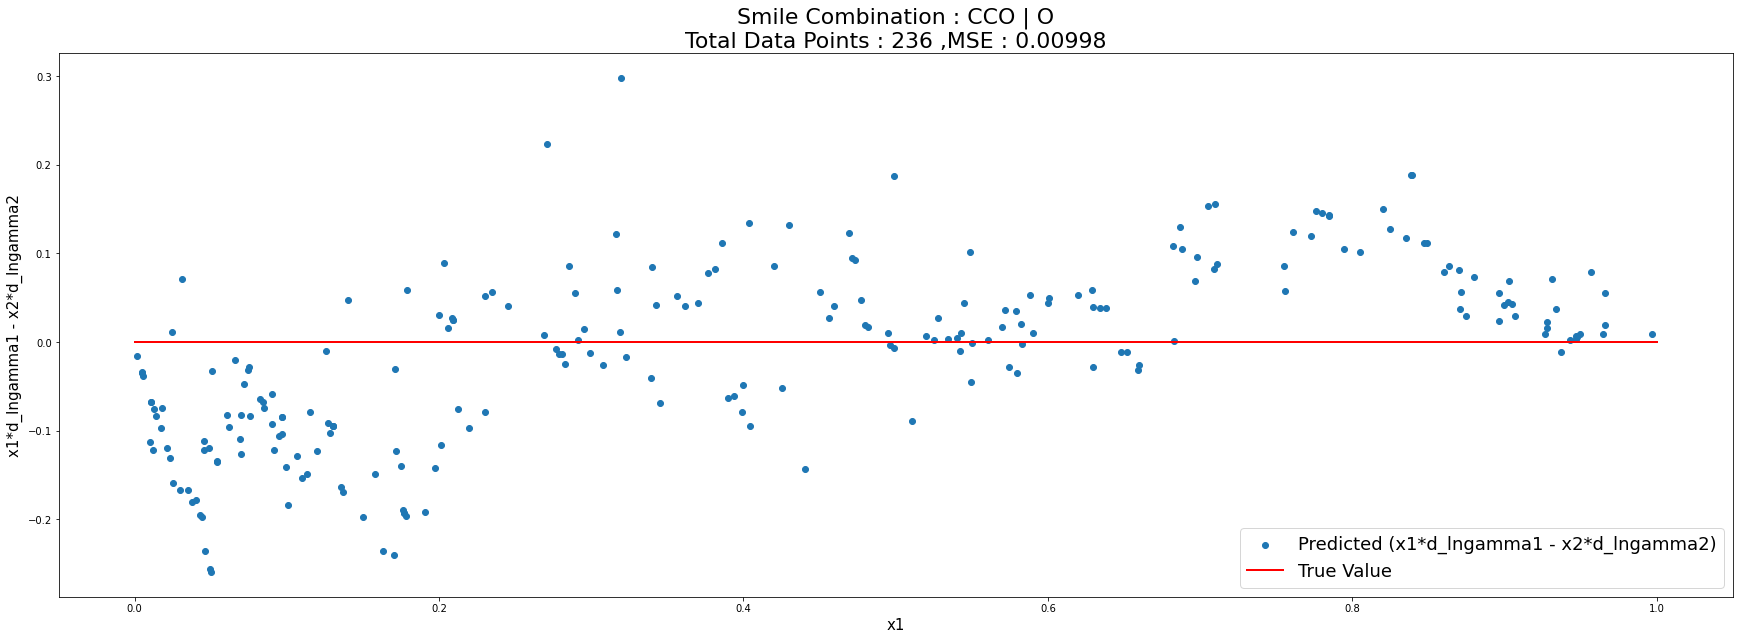

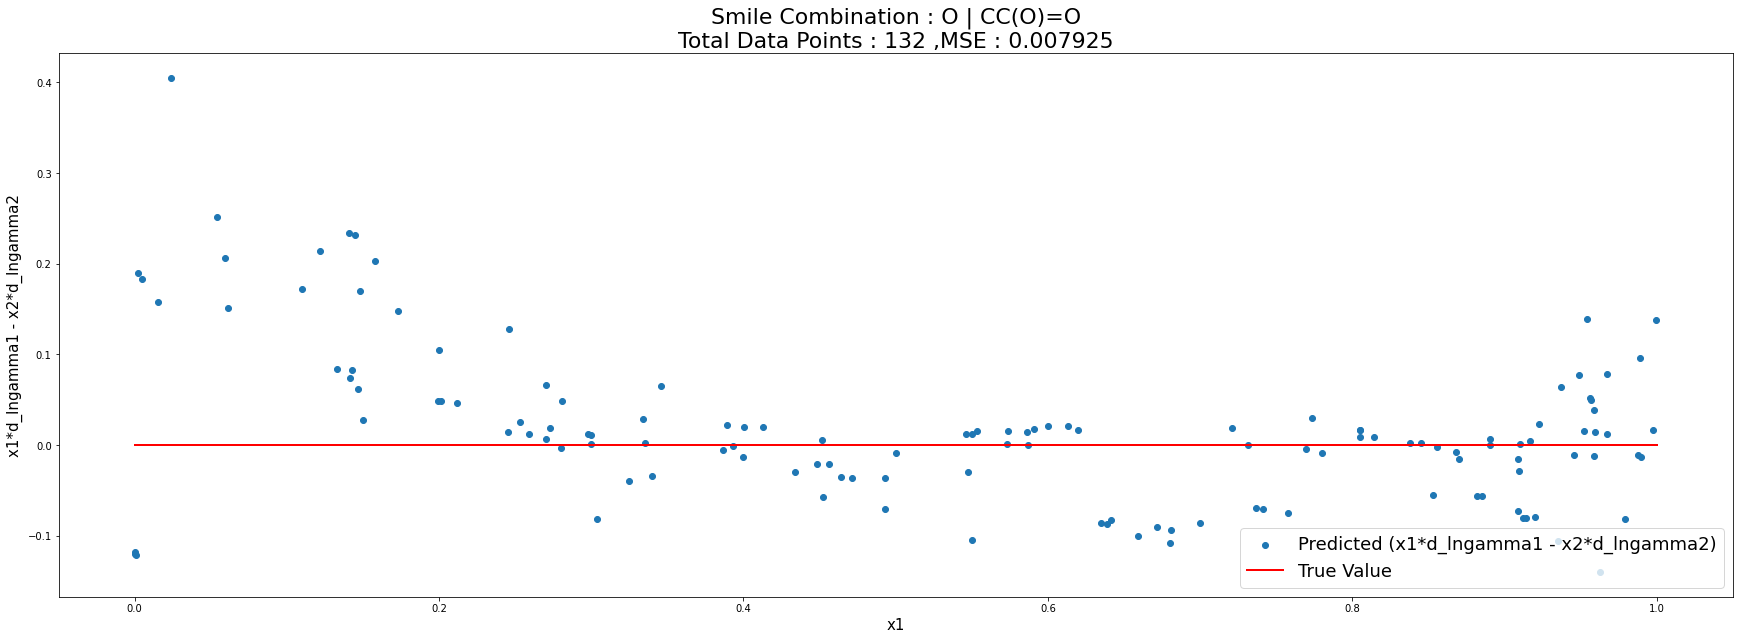

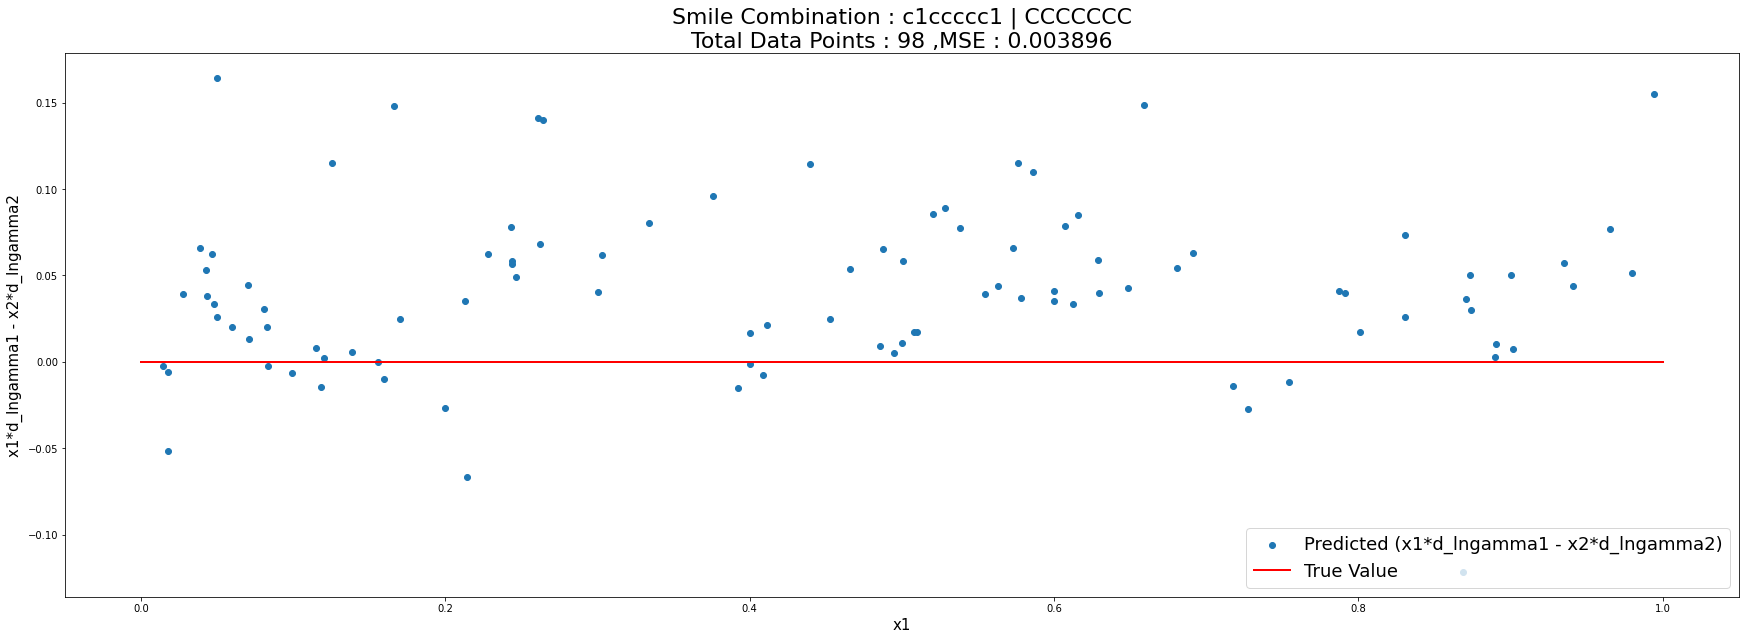

In [87]:
# data_subset = np.array(data_subset)
# Note that it is possible to get a negative R-square for equations that do not contain a constant term. 
# Because R-square is defined as the proportion of variance explained by the fit, if the fit is actually worse than just fitting a horizontal line then R-square is negative.
for i, j in zip(smile1,smile2):
    physics = evaluate(i, j, model.to(device))

## Generate new data and evaluate the model

In [88]:
# create a function to plot the predictions on test data. First, create a sample data from an existing unique test 
# data SMILE combination. Lets consider water-ethanol. Create a test dataset for water-ethanol combination for 
# constant temperature, and x1 from 0 to 1 with 0.01 intervals (should be 101 rows). 
# Similarly, x2 should be automatically (1-x1). Now, use our model to predict ln.gamma1 and ln.gamma2 for this input data.
# Plot the ln.gamma values against x1. Also, plot the ln.gamma values for this combination (and temperature maybe) 
# from the ground truth test dataset.

#### Predicts the ln(gamma) values for the new test data generated

In [4]:
def prediction(smile1, smile2, model):
    
    # CREATE SYNTHETIC DATASET FOR TESTING PURPOSE
    new_test_data, test_ground_truth, temperature = create_new_test_data(smile1, smile2)
    
    # GENERATED TEST DATA
    new_test_data = Variable(torch.from_numpy(new_test_data)).float()
    
    X = new_test_data[:,:-2]
    y = new_test_data[:,-2:]
        
    y_pred = model(X)
    ln_gamma1 = y_pred[:,0]
    ln_gamma2 = y_pred[:,1]
        
    x1 = X[:,-3]
    
    # Truth value from the dataset
    X_true = test_ground_truth[:,:-2]
    y_true = test_ground_truth[:,-2:]
    
    x1_true = X_true[:,-3]
    ln_gamma1_true = y_true[:,0]
    ln_gamma2_true = y_true[:,1]
    
    # Plot the graphs of truth values and predicted values
    fig = plt.figure(figsize=(30,10))
    plt.scatter(x1.detach().numpy(), ln_gamma1.detach().numpy(), label='Predicted ln_gamma1 of generated data (' + str(len(x1)) + ' data points)',c='blue')
    plt.scatter(x1.detach().numpy(), ln_gamma2.detach().numpy(), label='Predicted ln_gamma2 of generated data (' + str(len(x1)) + ' data points)',c='cyan')
    
    plt.scatter(x1_true, ln_gamma1_true, label = 'True ln_gamma1 value from existing data (' + str(len(x1_true)) + ' data points)',c='red')
    plt.scatter(x1_true, ln_gamma2_true, label = 'True ln_gamma2 value from existing data (' + str(len(x1_true)) + ' data points)',c='green')
    
    plt.xlabel('x1', fontsize='15')
    plt.ylabel('ln(gamma) values', fontsize='15')
    
#     plt.title('Smile Combination : ' + smile1 + ' | ' + smile2 + ' \nTemperature : ' + str(temperature) + ' °C, ' + 'Correlation : ' + str(corr_ln_gamma1) + ' ' + str(corr_ln_gamma2),fontsize=22)
    plt.title('Smile Combination : ' + smile1 + ' | ' + smile2 + ' \nTemperature : ' + str(temperature) + ' °C',fontsize=22)
    plt.legend(fontsize=18)
    
    plt.ylim(-0.5,2.0)

    plt.show()

#### Creates a new test data (100 points) AND returns the data for a particular temperature from existing data

In [5]:
def create_new_test_data(smile1, smile2):
    
    # Fetch the whole data
    output = pd.read_csv("test_data_seed_10_smile_combination_2.csv")
    output.drop(['Unnamed: 0'],inplace=True, axis=1)
    
    data = output.copy()
    data.reset_index(drop=True,inplace=True)    
    
    # Get a subset of data
    data_subset = data[(data['SMILES_1'] == smile1) & (data['SMILES_2'] == smile2) | (data['SMILES_1'] == smile2) & (data['SMILES_2'] == smile1)].sort_values(['x1'])
    
    # Get the temperature value.
    temperature = get_most_frequent_temp(smile1, smile2, data_subset)
    
    data_subset.drop(['SMILES_1','SMILES_2'],inplace=True,axis=1)
    data_subset.reset_index(inplace=True,drop=True)
    
    # Ground truth
    test_ground_truth = data_subset[data_subset['T / °C'] == temperature]
    
    # Generate new testdata
    new_test_data = test_ground_truth.head(1)

    x = np.arange(0,1,0.01)
        
    new_test_data = pd.concat([new_test_data]*100, ignore_index=True)

    for i, x1 in enumerate(x):
        new_test_data.loc[i, 'x1'] = x1
        new_test_data.loc[i, 'x2'] = 1-x1
        
    return np.array(new_test_data), np.array(test_ground_truth), temperature

In [6]:
def get_most_frequent_temp(smile1, smile2, data):
    
    data_subset = data[(data['SMILES_1']==smile1) & (data['SMILES_2']==smile2) | (data['SMILES_2']==smile1) & (data['SMILES_1']==smile2)]
    max_frequency = data_subset.groupby('T / °C').count()['x1'].max()
    all_temperature_count = data_subset.groupby('T / °C').count()['x1']
    temperature = all_temperature_count[all_temperature_count == max_frequency].index[0]
    
    return temperature

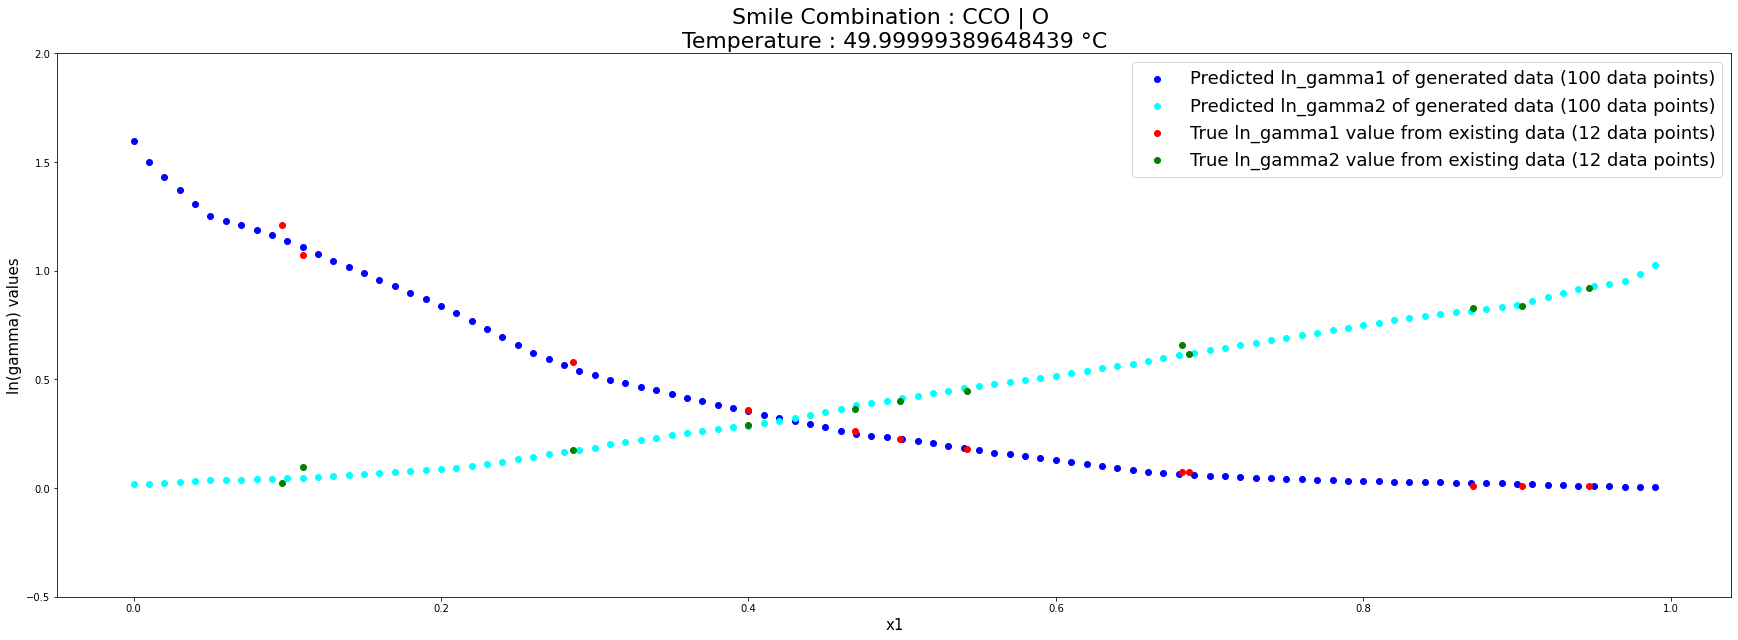

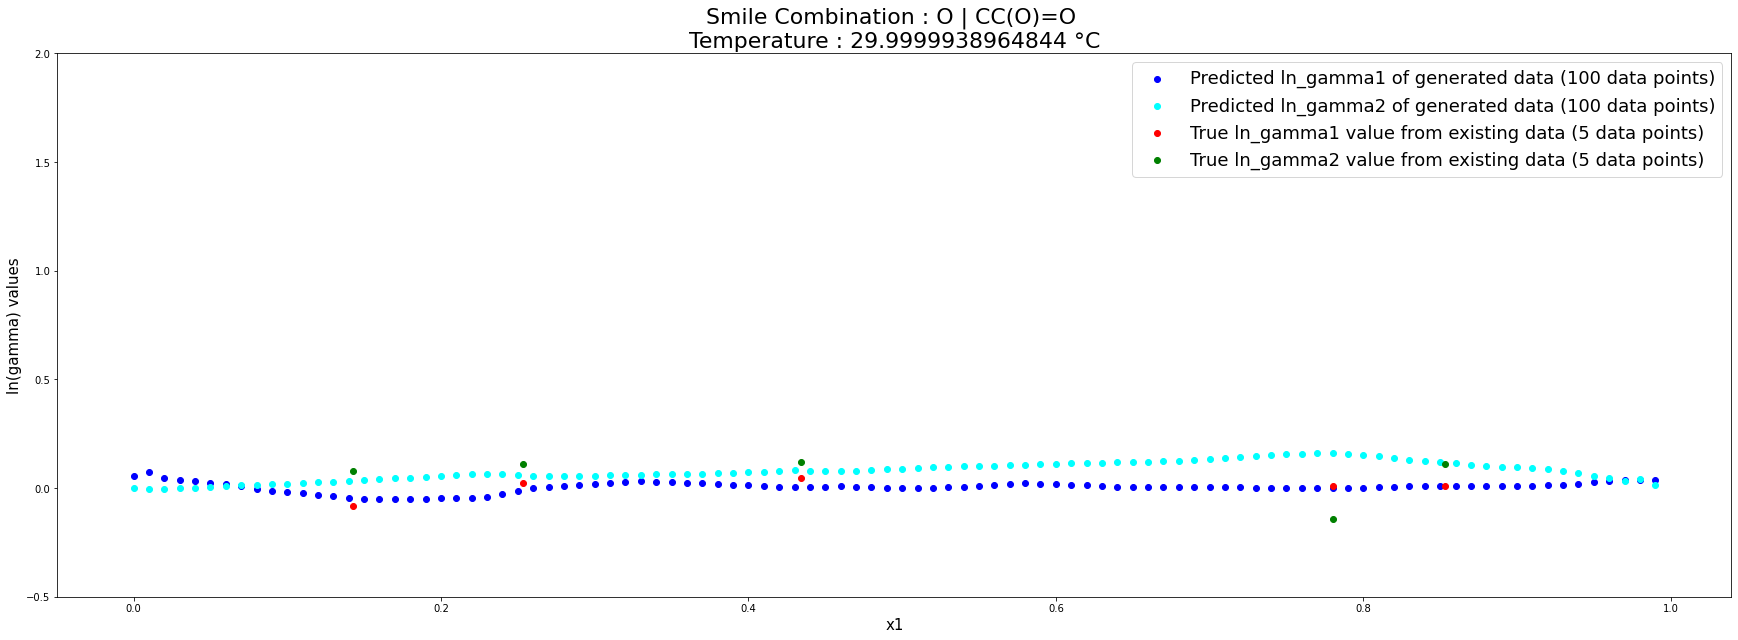

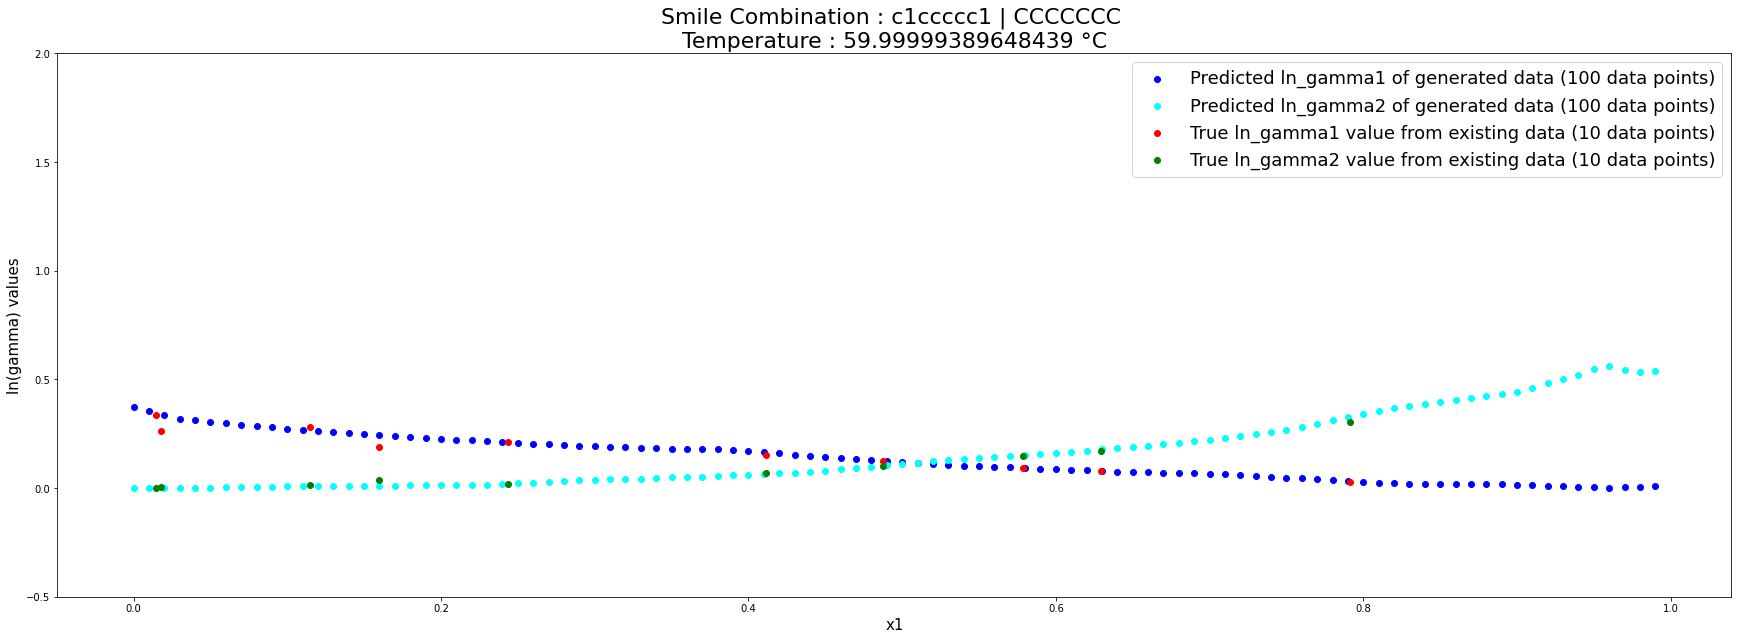

In [92]:
for i, j in zip(smile1, smile2):
    prediction(i, j, model)

### Graph Area Evaluation

In [93]:
# data = pd.read_pickle("./Dataset_after_cleaning_or_embedding/clean_embedded_flatten_data.pkl")
# output = pd.read_csv("./Embeddings_train_from_scratch/flatten_embedded_data.csv")
output = pd.read_csv("test_data_seed_10_smile_combination_2.csv")
output.drop(['Unnamed: 0'],inplace=True, axis=1)

data = output.copy()
data.reset_index(drop=True,inplace=True)

In [94]:
data

,0,1,2,3,4,5,6,7,8,9,...,2797,2798,2799,SMILES_1,SMILES_2,x1,x2,T / °C,2805,2806
0,-0.005265,0.347709,-0.073070,-0.016453,0.112440,-0.230354,0.032877,-0.087410,-0.081202,0.237213,...,0.0,0.0,0.0,CCOC(C)=O,ClCCBr,0.1914,0.8086,39.999994,-0.082582,0.027736
1,0.355710,-0.069599,0.654695,-0.132298,-0.022892,0.004550,0.120747,-0.060143,-0.123702,0.076386,...,0.0,0.0,0.0,CC1CCCCC1,Cc1ccc(C)cc1,0.6480,0.3520,109.119989,0.064840,0.019372
2,-0.074237,0.007232,0.209135,-0.014637,-0.201342,-0.289365,-0.137301,0.214193,-0.294719,0.107033,...,0.0,0.0,0.0,CCCCCCCC,CCC1CCCCC1,0.3880,0.6120,129.360010,-0.014987,0.004154
3,0.015686,0.231036,0.083759,-0.291475,0.023816,-0.071031,0.043757,-0.097784,-0.130814,0.060833,...,0.0,0.0,0.0,O,OCc1occc1,0.0130,0.9870,88.499994,1.237340,0.143069
4,-0.308645,-0.448670,-0.039165,0.167098,-0.291642,-0.170552,0.454936,-0.483263,-0.196898,-0.180987,...,0.0,0.0,0.0,O=Cc1ccccc1,CC(=O)OCc1ccccc1,0.6000,0.4000,123.200006,-0.003804,-0.385656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16613,0.183045,-0.058382,0.619622,0.032305,-0.135840,0.222286,0.055416,0.026002,-0.136855,0.036765,...,0.0,0.0,0.0,Cc1ccccc1,C/1C\C=C\CC\C=C/CC\C=C1,0.4000,0.6000,144.999994,-0.046532,-0.777674
16614,0.105997,0.077130,0.177014,-0.013871,-0.102601,0.216836,-0.078661,-0.099561,-0.366107,-0.001014,...,0.0,0.0,0.0,c1ccccc1,CCCCO,0.8003,0.1997,121.700006,0.041102,0.580859
16615,0.105997,0.077130,0.177014,-0.013871,-0.102601,0.216836,-0.078661,-0.099561,-0.366107,-0.001014,...,0.0,0.0,0.0,c1ccccc1,CC(C)(C)O,0.2330,0.7670,69.999994,0.681774,-0.019288
16616,0.105997,0.077130,0.177014,-0.013871,-0.102601,0.216836,-0.078661,-0.099561,-0.366107,-0.001014,...,0.0,0.0,0.0,c1ccccc1,C1CCCCC1,0.5552,0.4448,129.999994,0.051665,0.077301


In [99]:
model.to(device)

Model2(
  (layer1): Linear(in_features=2803, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=2, bias=True)
)

In [101]:
def area_test(smile1, smile2, data):
        
    temperature = get_most_frequent_temp(smile1, smile2, data)    
#     data_subset = data[(data['SMILES_1']==smile1) & (data['SMILES_2']==smile2) | (data['SMILES_2']==smile1) & (data['SMILES_1']==smile2)]
#     data_subset.drop(['SMILES_1','SMILES_2'], inplace=True, axis=1)
#     data_subset.sort_values(['x1'],inplace=True)
    
#     data_subset = np.array(data_subset[ data_subset['T / °C'] == temperature])
        
#     X = data_subset[:,:-2]
#     y = data_subset[:,-2:]

    ###
    X = test_data[:,:-2]
    y = test_data[:,-2:]
    ###
    
    X = Variable(torch.from_numpy(X)).float().requires_grad_(True)
    y = Variable(torch.from_numpy(y)).float()
    
    # Getting x1 and x2 concentration from the input data
    x1 = X[:,-3]
    x2 = X[:,-2]
    
    # Prediction of ln(gamma1) and ln(gamma2) using the PINN Model
    y_pred = model(X)  
        
    values = y_pred[:,0] - y_pred[:,1]
    
    fig = plt.figure(figsize=(10,12))
    plt.plot(x1.detach().numpy(), values.detach().numpy())
    
    A = values[values > 0].detach().numpy()
    B = values[values < 0].detach().numpy()
    
#     plt.fill_between(x1.detach().numpy(),0, values.detach().numpy(),color='blue')
#     plt.fill_between(x1[:len(A)].detach().numpy(),0, A,color='red')

    plt.fill_between(x1.detach().numpy(),0, values.detach().numpy(), where=(values.detach().numpy()>=0),color='red')
    plt.fill_between(x1.detach().numpy(),0, values.detach().numpy(), where=(values.detach().numpy()<=0),color='blue')

    
    area_A=np.trapz(A, x1[:len(A)].detach().numpy())
    area_B=np.trapz(np.abs(B), x1[len(A):].detach().numpy()) 

    
    D = (np.abs(area_A - area_B) / (area_A + area_B)) * 100    
        
    plt.plot(range(0,2),np.zeros(2),color='black',linewidth=2,label='True Value')
    plt.xlabel('x1')
    plt.ylabel('ln (gamma1 / gamma2)')
    plt.title('Thermodynamic consistency with the help of the area test\nSMILE COMBINATION : ' + smile1 + ' | ' + smile2 + ' ,#Data Points : ' + str(len(X)) + '\nTemperature : ' + str(temperature),fontsize=20)
    plt.text(0.4,0.1,'D = ' + str(round(D,2))+'%',fontsize=15)
    plt.ylim(-2,2.3)

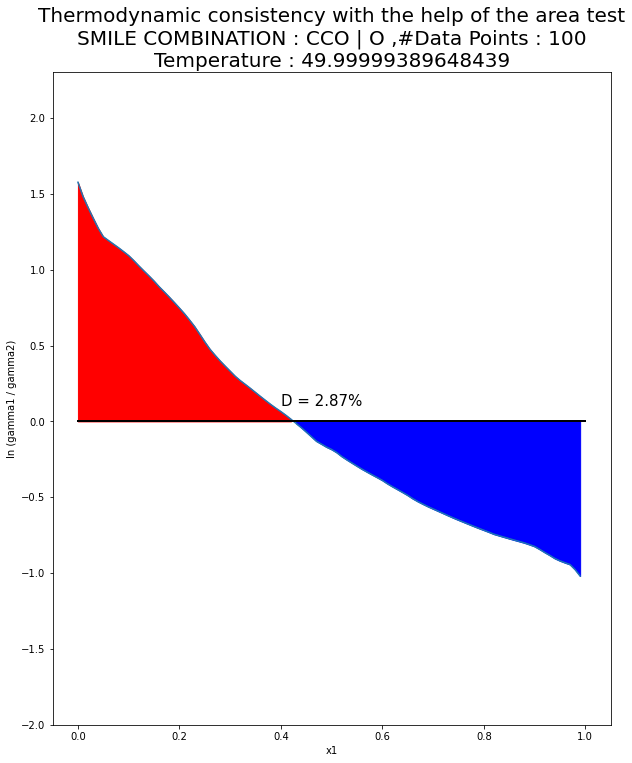

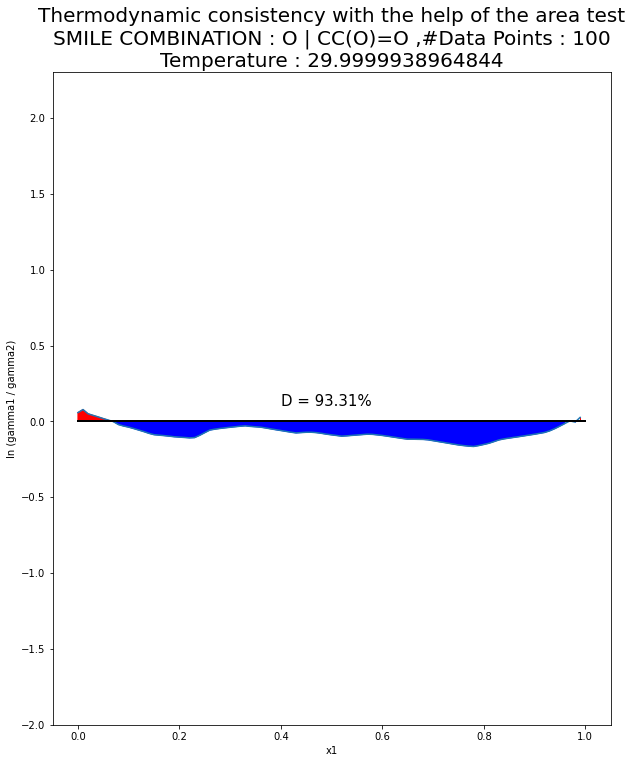

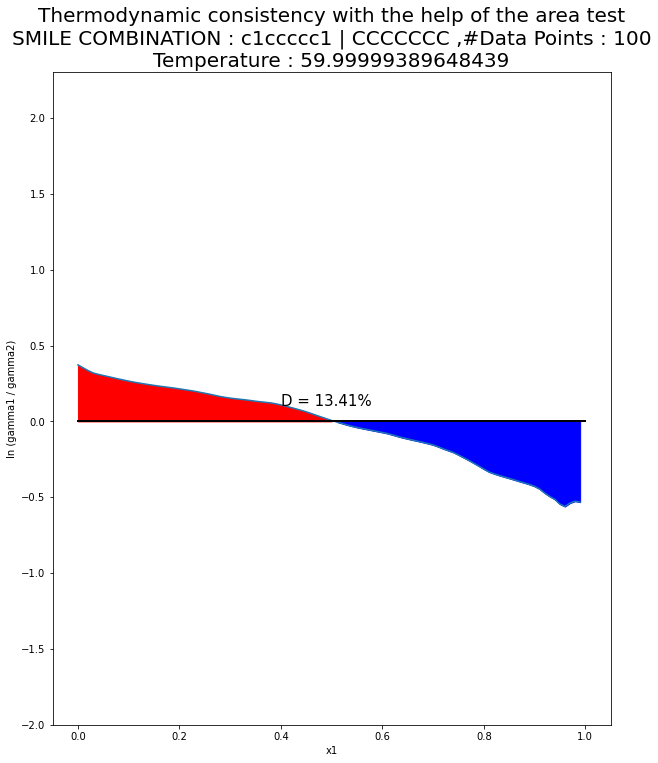

In [102]:
for i,j in zip(smile1,smile2):
    # Create data for evaluation.
    temp = get_most_frequent_temp(i,j,data)
    test_data, test_ground_truth, temp = create_new_test_data(i, j)
    area_test(i, j, data)